In [1]:
import wrf
import cartopy.crs as ccrs
import netCDF4 as nc
import glob
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pyart
import zipfile
import datetime as dt
import os
import tqdm
import pandas as pd
import warnings

warnings.simplefilter("ignore")

def plot_radar(rid, time, lon, lat, ax, sweep=1, plot_cbar=False, cax=[0.2,0.08,0.6,0.01]):
    
    radar = load_radar(rid, time)
    disp=pyart.graph.GridMapDisplay(radar)
    if rid=="2":
        min_lon=143; max_lon=146; min_lat=-39.5; max_lat=-36.5
    if rid=="68":
        min_lon=145; max_lon=148; min_lat=-39.5; max_lat=-36.5        
    elif rid=="40":
        min_lon=147; max_lon=151; min_lat=-36.5; max_lat=-33.5
    elif rid=="71":
        min_lon=149; max_lon=152; min_lat=-35; max_lat=-32
    elif rid=="56":
        min_lon=142; max_lon=145; min_lat=-24; max_lat=-21
    elif rid=="8":
        min_lon=151; max_lon=154; min_lat=-27.5; max_lat=-24.5
    elif rid=="50":
        min_lon=151; max_lon=154; min_lat=-29; max_lat=-26
    elif rid=="66":
        min_lon=150; max_lon=155; min_lat=-29; max_lat=-25
    x,y = radar.get_point_longitude_latitude()
    c=ax.pcolormesh(x, y, np.nanmax(radar.fields["corrected_reflectivity"]["data"],axis=0),
                   cmap=pyart.graph.cm_colorblind.HomeyerRainbow, vmin=0, vmax=60)
    ax.set_ylim([min_lat, max_lat])
    ax.set_xlim([min_lon, max_lon])
    ax.plot(lon, lat, marker="x", mew=2, ms=12, color="k")
    if plot_cbar:
        cb=plt.colorbar(c, cax=plt.axes(cax), orientation="horizontal", extend="both")
        cb.set_label("Reflectivity (DBZ)")
    return disp
    
def unpack_level1b(rid, times):
        #Unzip level1b data between times[0] and times[1], and save to scratch
        assert times[0].year == times[1].year, "Times range must be within calendar year"
        files = np.array(glob.glob("/g/data/rq0/level_1b/"+rid+"/grid/"+str(times[0].year)+"/*.zip"))
        if len(files) == 0:
                print("NO FILES FOUND FOR RID: ")#+rid+" AND TIMES "+times[0]+" "+times[-1])
        file_dates = np.array([dt.datetime.strptime(f.split("/")[8].split("_")[1], "%Y%m%d") for f in files])
        target_files = files[(file_dates >= times[0].replace(hour=0, minute=0)) & (file_dates <= times[1].replace(hour=0, minute=0))]
        extract_to = "/scratch/eg3/ab4502/tint/"
        for f in target_files:
                with zipfile.ZipFile(f, "r") as zip_ref:
                        zip_ref.extractall(extract_to)    
    
def load_radar(rid, time):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    times = [time+dt.timedelta(seconds=-60*6), time]
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
    
    radar_file = pyart.io.read_grid(target_files[0])
    
    _ = [os.remove(f) for f in target_files]
    
    return radar_file 

def load_radar_range(rid, times):

    #time: Time of interest (in this context, the time of maximum BARPAC gust). datetime object
    #rid: Radar ID (https://www.openradar.io/operational-network). two-digit string
    #radar_t_delta: Add some interval (in minutes) to look at a time relative to the time of maximum model gust. integer
    

    #Unpack gridded radar files. Create empty files based on missing files reported in Level 2
    unpack_level1b(rid, times)
    grid_files = np.sort(glob.glob("/scratch/eg3/ab4502/tint/"+rid+"*_grid.nc"))
    file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                    "%Y%m%d%H%M%S") for f in grid_files])
    target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]    
    
    out = []
    time_out = []
    for f in tqdm.tqdm(target_files):
            radar_file = pyart.io.read_grid(f).to_xarray().corrected_reflectivity.isel({"time":0}).max("z")
            out.append(radar_file.values)
            time_out.append(radar_file.time.values)
    
    _ = [os.remove(f) for f in target_files]
    
    return out, time_out, radar_file.lon.values, radar_file.lat.values


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
wrflist = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20150227_20150301/wrfout*d03*"))]
wrflist_d02 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20150227_20150301/wrfout*d02*"))]
wrflist_d03 = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20150227_20150301/wrfout*d01*"))]

wrflist_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20150227_20150301/highres*d03*"))]
wrflist_d02_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20150227_20150301/highres*d02*"))]
wrflist_d03_hr = [nc.Dataset(f) for f in np.sort(glob.glob("/g/data/eg3/ab4502/WRF_simulations/vic_d03_20150227_20150301/highres*d01*"))]

In [3]:
U10E = np.vstack([f["U10E"][:] for f in wrflist_hr])
V10E = np.vstack([f["U10E"][:] for f in wrflist_hr])
speed = np.sqrt(U10E**2+V10E**2)
times = wrf.extract_times(wrflist_hr,wrf.ALL_TIMES)

In [5]:
aws = pd.read_csv("/g/data/eg3/ab4502/ExtremeWind/obs/aws/vic_one_min_gust/2015.csv")

<AxesSubplot:xlabel='dt_utc'>

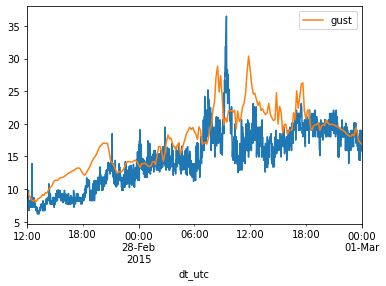

In [7]:
aws = aws.set_index(pd.DatetimeIndex(aws.dt_utc))

ax=plt.axes()
aws.loc[slice("2015-02-27 12:00","2015-03-01 00:00")].groupby(level=0).max().gust.plot(ax=ax)
pd.DataFrame({"gust":np.max(speed,axis=(1,2))}, index=times).plot(color="tab:orange",ax=ax)

In [24]:
hourly_times = []
t0=dt.datetime(2015,2,28,5)
hours=8
for t in np.arange(hours):
    t_temp = t0 + dt.timedelta(hours=float(t))
    print(t_temp)
    hourly_times.append(t_temp)

a, b, lon, lat =load_radar_range("2",[t0+ dt.timedelta(hours=-1),hourly_times[-1]])

a=np.stack(a)
b=np.stack(b)

hourly_radar = []
for t_temp in hourly_times:
    hourly_radar.append(np.nanmax(a[(b> (t_temp+dt.timedelta(hours=-1))) & (b<t_temp)],axis=0))

2015-02-28 05:00:00
2015-02-28 06:00:00
2015-02-28 07:00:00
2015-02-28 08:00:00
2015-02-28 09:00:00
2015-02-28 10:00:00
2015-02-28 11:00:00
2015-02-28 12:00:00


100%|██████████| 80/80 [00:20<00:00,  3.93it/s]


In [25]:
def plot(file_list,v,t_ind,ax,levels=None,cmap=None,lev=None):
    
    #Code to plot la-lon contours of various quantities
    
    if v == "REFL_10CM":
        p1 = wrf.getvar(file_list, v, timeidx=wrf.ALL_TIMES, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"Time":t_ind}).max("bottom_top"),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    elif v == "THETA":
        p1 = wrf.getvar(file_list, "theta", timeidx=t_ind, method="cat")
        time=p1.Time.values
        c=xr.plot.contourf(p1.isel({"bottom_top":0}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)      
    elif v == "THETA-E":
        p1 = wrf.getvar(file_list, "theta_e", timeidx=t_ind, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"bottom_top":0}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)              
    elif v == "W_MIN":
        heights = wrf.getvar(file_list,"z",timeidx=t_ind)
        p1 = wrf.getvar(file_list, "wa", timeidx=t_ind, method="cat")
        time=p1.Time.values[t_ind]
        p1 = xr.where(heights < 3000, p1, np.nan)
        c=xr.plot.contourf(p1.min("bottom_top"),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)        
    elif v == "W":
        heights = wrf.getvar(file_list,"z",timeidx=t_ind)
        p1 = wrf.getvar(file_list, "wa", timeidx=t_ind, method="cat")
        time=p1.Time.values
        p1 = wrf.interplevel(p1,heights,lev)
        c=xr.plot.contourf(p1,x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)                
    elif v == "WS10":
        p1 = wrf.getvar(file_list, "U10E", timeidx=wrf.ALL_TIMES, method="cat")
        time=p1.Time.values[t_ind]
        p2 = wrf.getvar(file_list, "V10E", timeidx=wrf.ALL_TIMES, method="cat")
        p=np.sqrt(p1**2+p2**2)
        p.attrs=p1.attrs
        c=xr.plot.contourf(p.isel({"Time":t_ind}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    else:
        p1 = wrf.getvar(file_list, v, timeidx=wrf.ALL_TIMES, method="cat")
        time=p1.Time.values[t_ind]
        c=xr.plot.contourf(p1.isel({"Time":t_ind}),x="XLONG",y="XLAT",transform=ccrs.PlateCarree(),ax=ax,levels=levels,cmap=cmap)
    plt.title(time)

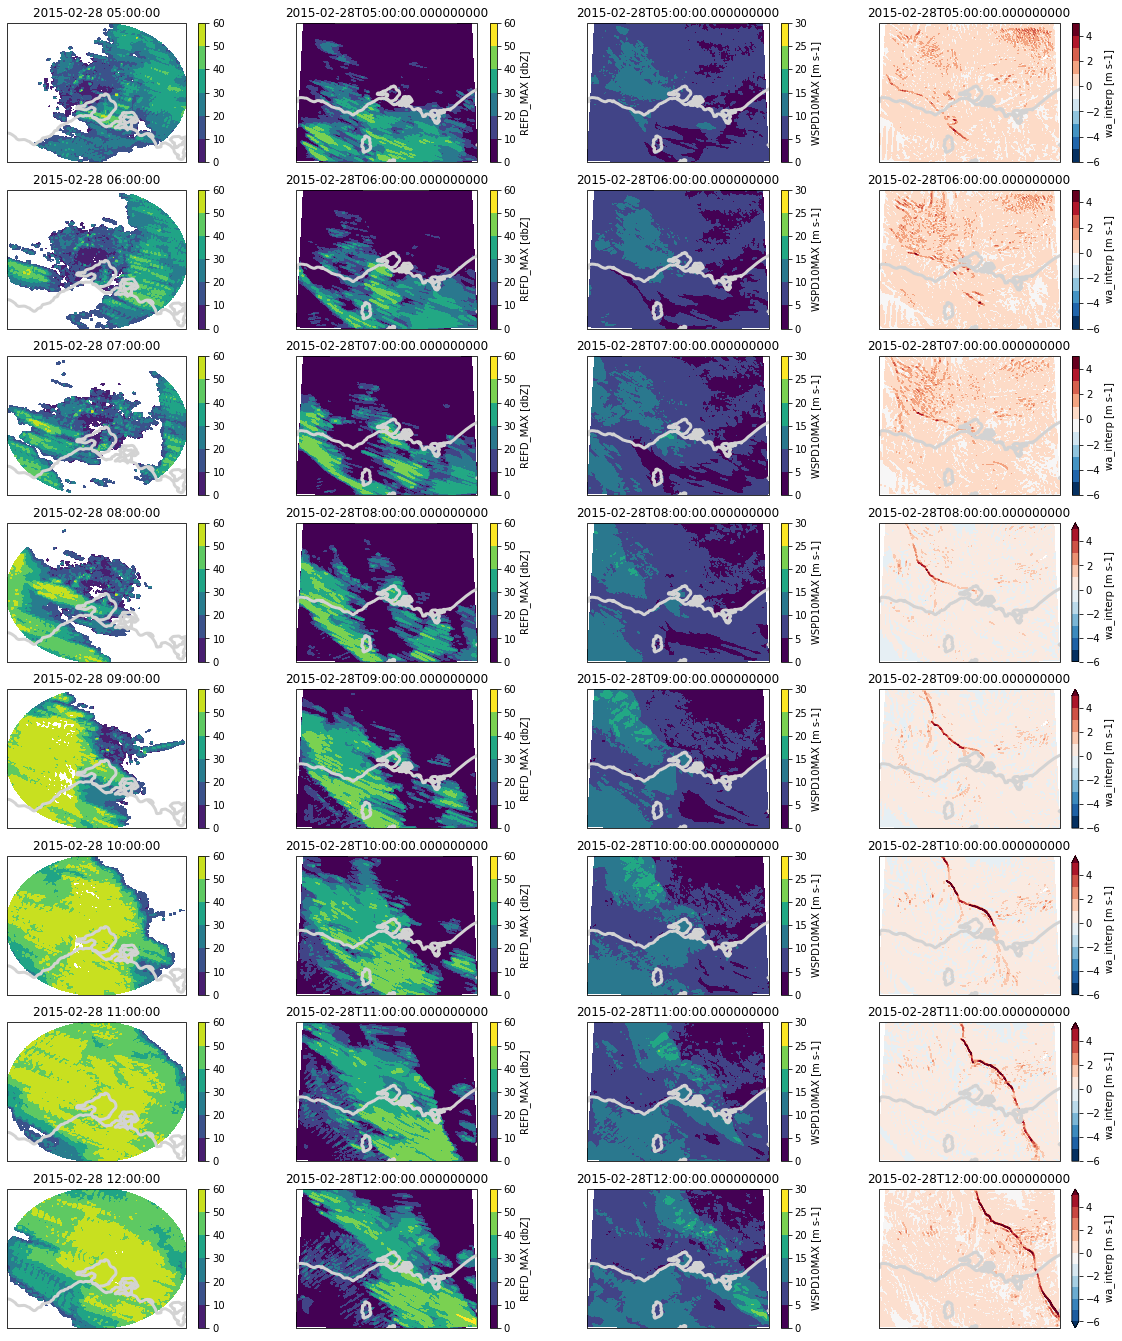

In [37]:
plt.figure(figsize=[20,24])

rows=8;cols=4
t0=17

cnt=0
x,y = np.meshgrid(lon,lat)
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+1,projection=ccrs.PlateCarree())
    c=ax.contourf(x,y,hourly_radar[cnt],levels=np.arange(0,70,10))
    ax.coastlines(color="lightgray",lw=3)
    ax.set_title(hourly_times[cnt])
    plt.colorbar(c)
    cnt=cnt+1
    
cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+2,projection=ccrs.PlateCarree())
    plot(wrflist,"REFD_MAX",t0+cnt,ax,levels=np.arange(0,70,10))
    ax.coastlines(color="lightgray",lw=3)
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+3,projection=ccrs.PlateCarree())
    plot(wrflist,"WSPD10MAX",t0+cnt,ax,levels=np.arange(0,35,5))
    ax.coastlines(color="lightgray",lw=3)
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+4,projection=ccrs.PlateCarree())
    #plot(wrflist,"T2",t0+cnt,ax,levels=np.arange(290,317.25,2.5),cmap=plt.get_cmap("rainbow"))
    plot(wrflist,"W",t0+cnt,ax,levels=np.arange(-6,6,1),lev=1500)#cmap=plt.get_cmap("Blues_r"))
    
    ax.coastlines(color="lightgray",lw=3)
    cnt=cnt+1
    
plt.savefig("/g/data/eg3/ab4502/figs/wrf_20150228.png",box_inches="tight")

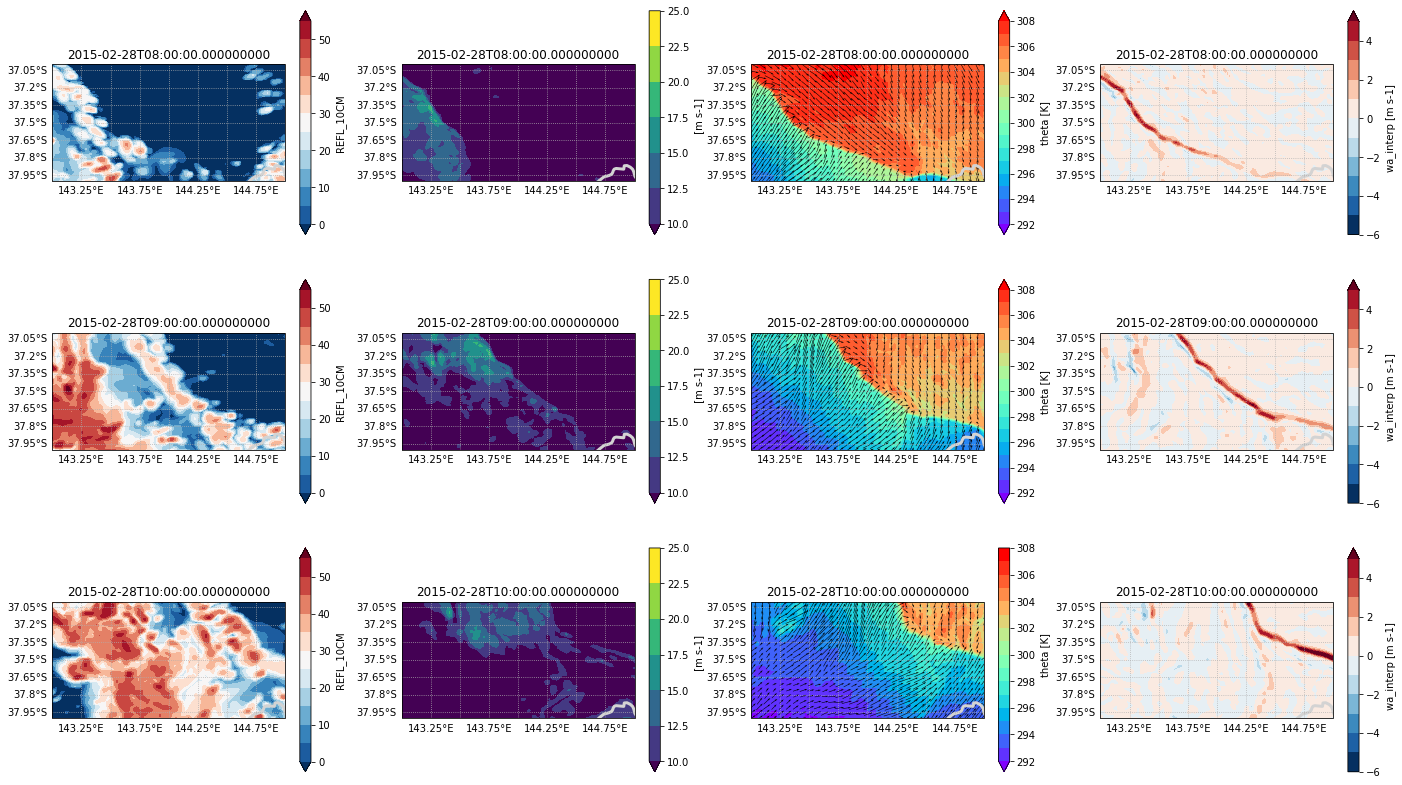

In [31]:
plt.figure(figsize=[24,14])

rows=3;cols=4
t0=20

#xlim = [143.8, 145.6]
#ylim = [-38.5, -37.2]
xlim = [143, 145]
ylim = [-38, -37]

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+4,projection=ccrs.PlateCarree())
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    plot(wrflist,"W",t0+cnt,ax,levels=np.arange(-6,6,1),lev=1500)#cmap=plt.get_cmap("Blues_r"))
    ax.coastlines(color="lightgray",lw=3)
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+1,projection=ccrs.PlateCarree())
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    plot(wrflist,"REFL_10CM",t0+cnt,ax,levels=np.arange(0,60,5))
    ax.coastlines(color="lightgray",lw=3)
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False    
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+2,projection=ccrs.PlateCarree())
    ax.set_xlim(xlim); ax.set_ylim(ylim)    
    plot(wrflist,"WS10",t0+cnt,ax,levels=np.arange(10,27.5,2.5))
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False    
    ax.coastlines(color="lightgray",lw=3)
    cnt=cnt+1

cnt=0
for i in np.arange(rows):
    ax=plt.subplot(rows,cols,i*cols+3,projection=ccrs.PlateCarree())
    ax.set_xlim(xlim); ax.set_ylim(ylim)    
    plot(wrflist,"THETA",t0+cnt,ax,levels=np.arange(292,309,1),cmap=plt.get_cmap("rainbow"))
    ax.coastlines(color="lightgray",lw=3)
    g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
    
    u=wrf.getvar(wrflist,"U10",timeidx=t0+cnt)
    v=wrf.getvar(wrflist,"V10",timeidx=t0+cnt)
    xr.Dataset({"u":u,"v":v}).coarsen(dim={"south_north":4,"west_east":4},boundary="trim").mean().plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150)   
    plt.title(u.Time.values)    
    cnt=cnt+1
    
plt.savefig("/g/data/eg3/ab4502/figs/wrf_20150228_zoomed.png",box_inches="tight")

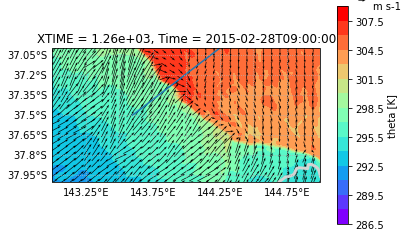

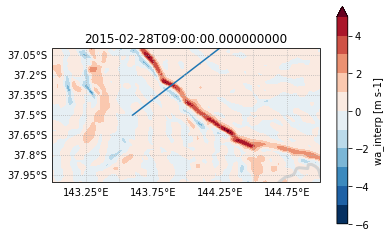

In [35]:
t_ind=21

lats = [-37.5,-37]
lons = [143.6, 144.25]

#PLOT THETA WITH TRANSECT
plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"THETA",t_ind,ax,levels=20,cmap=plt.get_cmap("rainbow"))
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False

u=wrf.getvar(wrflist,"U10",timeidx=t_ind)
v=wrf.getvar(wrflist,"V10",timeidx=t_ind)
xr.Dataset({"u":u,"v":v}).coarsen(dim={"south_north":4,"west_east":4},boundary="trim").mean().plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150)  
ax.plot(lons, lats)

#PLOT W WITH TRANSECT
plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"W",t_ind,ax,lev=1500,levels=np.arange(-6,6,1))
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False
ax.plot(lons, lats)

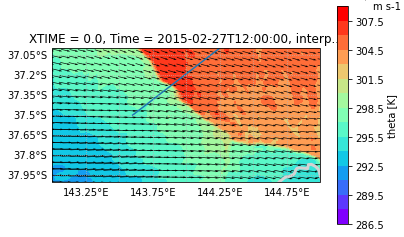

In [55]:
#PLOT THETA WITH TRANSECT
plt.figure()
ax=plt.axes(projection=ccrs.PlateCarree())
ax.set_xlim(xlim); ax.set_ylim(ylim)    
plot(wrflist,"THETA",t_ind,ax,levels=20,cmap=plt.get_cmap("rainbow"))
ax.coastlines(color="lightgray",lw=3)
g=ax.gridlines(draw_labels=True,linestyle=":"); g.top_labels=False; g.right_labels=False

u=wrf.vinterp(wrflist,wrf.getvar(wrflist,"ua"),"pressure",[850],timeidx=t_ind).isel({"interp_level":0})
v=wrf.vinterp(wrflist,wrf.getvar(wrflist,"va"),"pressure",[850],timeidx=t_ind).isel({"interp_level":0})
xr.Dataset({"u":u,"v":v}).coarsen(dim={"south_north":4,"west_east":4},boundary="trim").mean().plot.quiver("XLONG","XLAT","u","v",ax=ax,scale=150)  
ax.plot(lons, lats)

52.43140797117275


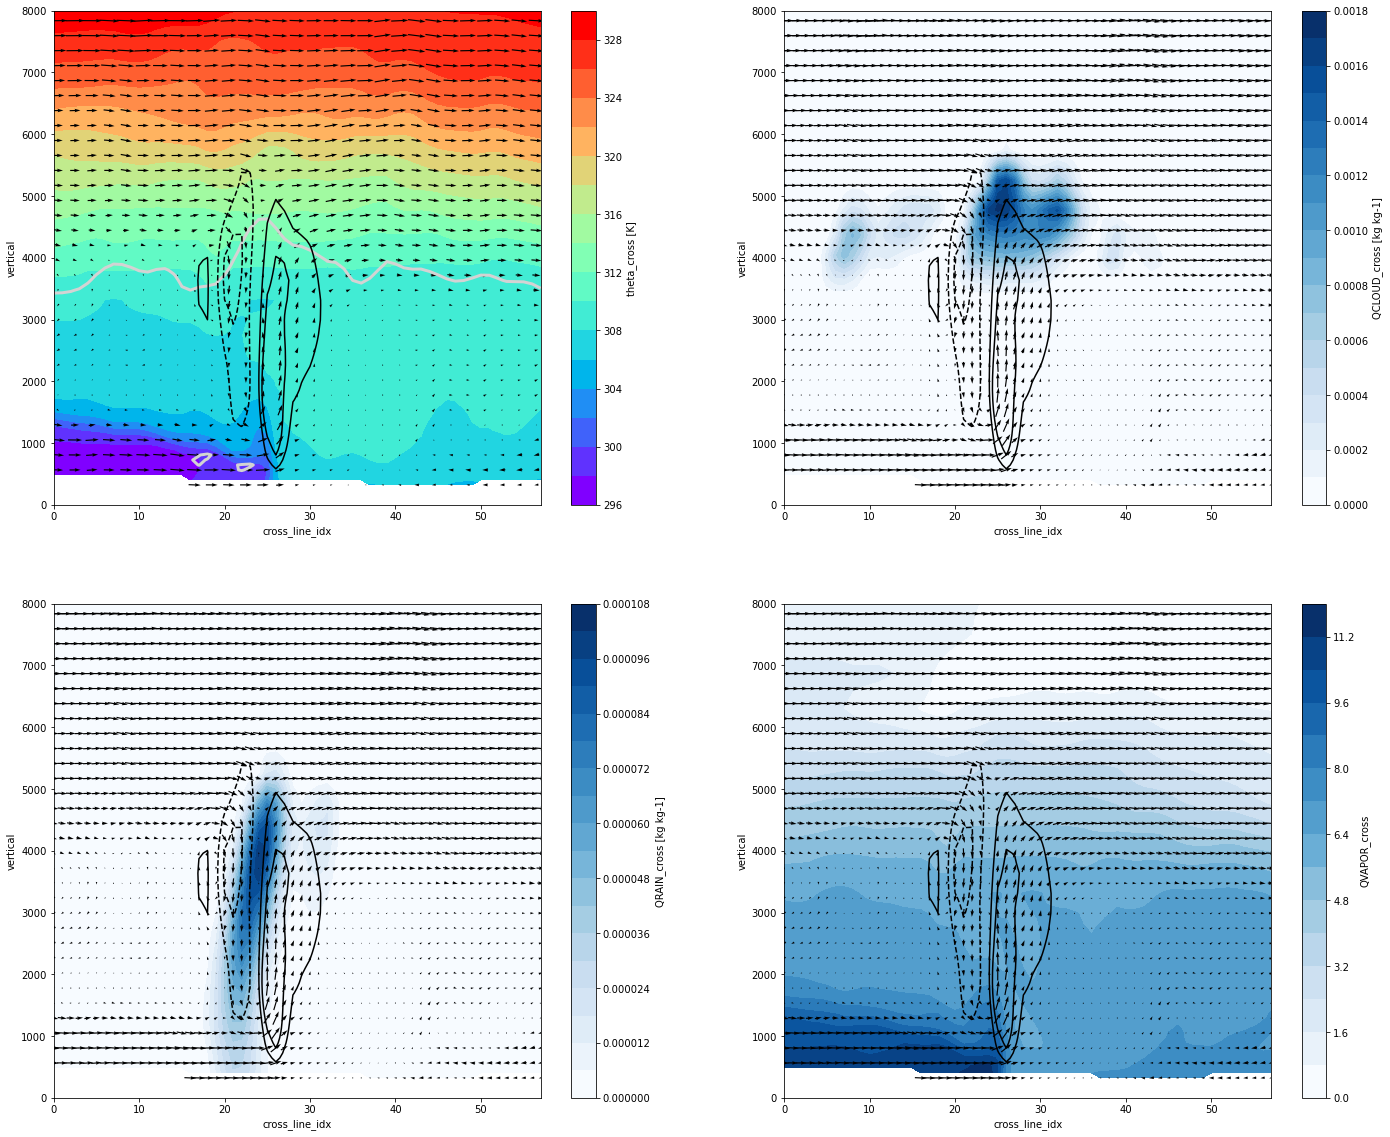

In [39]:
theta = wrf.getvar(wrflist,"theta",timeidx=t_ind)
heights = wrf.getvar(wrflist,"z",timeidx=t_ind)
U = wrf.getvar(wrflist,"U",timeidx=t_ind)
V = wrf.getvar(wrflist,"V",timeidx=t_ind)
QR = wrf.getvar(wrflist,"QRAIN",timeidx=t_ind)
QC = wrf.getvar(wrflist,"QCLOUD",timeidx=t_ind)
QV = wrf.getvar(wrflist,"QVAPOR",timeidx=t_ind)
W = wrf.destagger(wrf.getvar(wrflist,"W",timeidx=t_ind),0,meta=True)

start_point = wrf.CoordPair(lat=lats[0],lon=lons[0])
end_point = wrf.CoordPair(lat=lats[1],lon=lons[1])
y1=lats[0]; y2=lats[1]
x1=lons[0]; x2=lons[1]
angle = np.arctan2((x2-x1),(y2-y1))
print(np.rad2deg(angle))

top=8000
theta_cross = wrf.vertcross(theta,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
u_cross = wrf.vertcross(U,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
v_cross = wrf.vertcross(V,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
w_cross = wrf.vertcross(W,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point)
qr_cross = wrf.vertcross(QR,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)
qv_cross = wrf.vertcross(QV,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)
qc_cross = wrf.vertcross(QC,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,)

uu_cross = np.cos(angle) * u_cross - np.sin(angle) * v_cross
vv_cross = np.sin(angle) * u_cross + np.cos(angle) * v_cross

plt.figure(figsize=[24,20])

plt.subplot(2,2,1)
xr.plot.contourf(theta_cross,cmap=plt.get_cmap("rainbow"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":2,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=600)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[20],colors="lightgray",linewidths=3)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")

plt.subplot(2,2,2)
xr.plot.contourf(qc_cross,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=600)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")

plt.subplot(2,2,3)
xr.plot.contourf(qr_cross,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=600)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")

plt.subplot(2,2,4)
xr.plot.contourf(qv_cross*1000,cmap=plt.get_cmap("Blues"),levels=20)
xr.Dataset({"uu":vv_cross,"w":w_cross*5}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])}).drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=600)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")

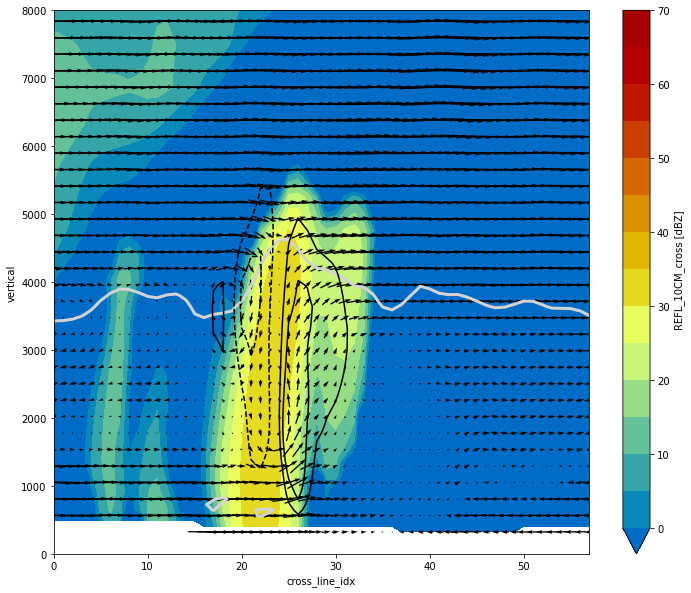

In [45]:
#Same plot but with model reflectivity

plt.figure(figsize=[12,10])

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*2}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})

REFL = wrf.getvar(wrflist,"REFL_10CM",timeidx=t_ind)
refl_cross = wrf.vertcross(REFL,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,latlon=True)

xr.plot.contourf(refl_cross,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(0,75,5))
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(np.sqrt(((uu_cross**2) + (vv_cross**2))),levels=[20],colors="lightgray",linewidths=3)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="k")

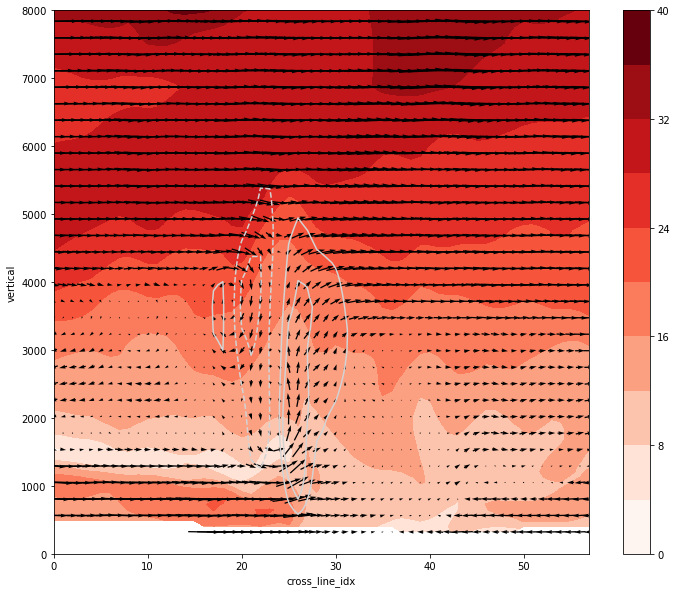

In [46]:
#Same plot but wind speed

plt.figure(figsize=[12,10])

wind_transect = xr.Dataset({"uu":vv_cross,"w":w_cross*2}).assign_coords({"cross_line_idx":np.arange(uu_cross.shape[1])})

#xr.plot.contourf(refl_cross,cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=np.arange(0,75,5))
xr.plot.contourf(np.sqrt(((uu_cross**2) + (vv_cross**2))),cmap=plt.get_cmap("Reds"),levels=10)
wind_transect.drop("xy_loc")\
        .coarsen(dim={"cross_line_idx":1,"vertical":3},boundary="trim").mean()\
        .plot.quiver("cross_line_idx","vertical","uu","w",scale=250)
xr.plot.contour(w_cross,levels=[-5,-2,-1,1,2,5],colors="lightgray")

In [11]:
radar=load_radar("2",dt.datetime(2015,2,28,9,0))

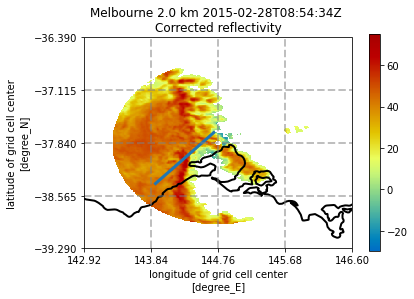

In [15]:
ax=plt.axes(projection=ccrs.PlateCarree())
disp=pyart.graph.GridMapDisplay(radar)
disp.plot_grid("corrected_reflectivity",level=4, ax=ax)

ax.plot([143.9,144.7],[-38.4,-37.7],color="tab:blue",lw=3)

In [16]:
from metpy.interpolate import cross_section
cross=cross_section(radar.to_xarray().isel({"time":0}).corrected_reflectivity.assign_coords(
    x=radar.to_xarray().lon,y=radar.to_xarray().lat).metpy.assign_crs(
    grid_mapping_name='latitude_longitude',
    earth_radius=6371229.0
),[-38.4,143.9],[-37.7,144.7],steps=50)

REFL = wrf.getvar(wrflist,"REFL_10CM",timeidx=t_ind)
refl_cross = wrf.vertcross(REFL,heights,wrfin=wrflist[t_ind],levels=np.linspace(0,top,100),start_point=start_point,end_point=end_point,latlon=True)

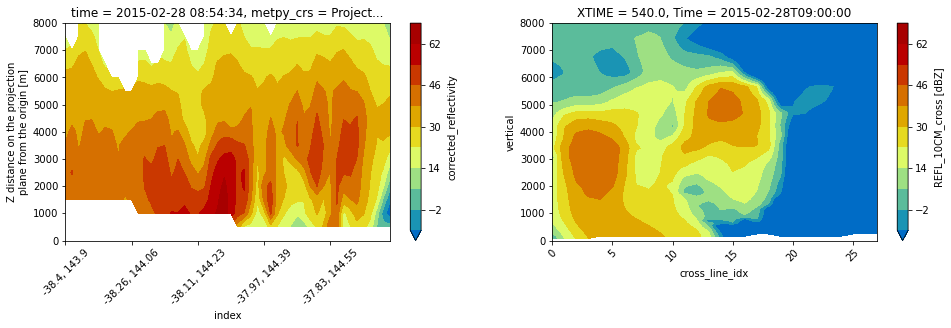

In [22]:
def get_xlabs(cross):
    lon_str = cross.lon.values.round(2).astype(str)
    lat_str = cross.lat.values.round(2).astype(str)
    xlab = [i + ", " + j for i, j in zip(lat_str,lon_str)]
    return xlab

plt.figure(figsize=[16,4])
plt.subplot(1,2,1)
xr.plot.contourf(cross,
    vmin=-10, 
    vmax=70, 
    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=11)
plt.ylim([0,8000])
plt.xticks(np.arange(0,50,10),get_xlabs(cross)[0::10])
plt.gca().tick_params(axis="x",rotation=45)

plt.subplot(1,2,2)
xr.plot.contourf(refl_cross,
    vmin=-10, 
    vmax=70, 
    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,levels=11)
#plt.xticks(np.arange(0,30,5),[refl_cross.sel({"cross_line_idx":slice(12,40)}).isel({"cross_line_idx":np.arange(0,30,5)}).xy_loc.values[i].latlon_str(fmt='{:.2f}, {:.2f}') for i in np.arange(len(np.arange(0,30,5)))])
plt.gca().tick_params(axis="x",rotation=45)

In [23]:
cross=cross_section(radar.to_xarray().isel({"time":0}).corrected_velocity.assign_coords(
    x=radar.to_xarray().lon,y=radar.to_xarray().lat).metpy.assign_crs(
    grid_mapping_name='latitude_longitude',
    earth_radius=6371229.0
),[-38.4,143.9],[-37.7,144.7],steps=50)

(0.0, 10000.0)

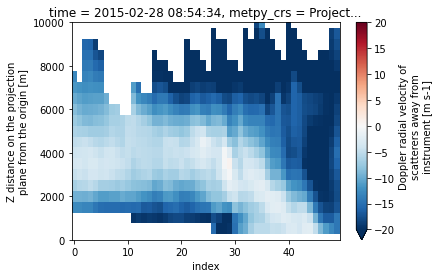

In [28]:
cross.plot(vmin=-20,vmax=20,cmap=plt.get_cmap("RdBu_r"))
plt.ylim([0,10000])

(0.0, 55.0)

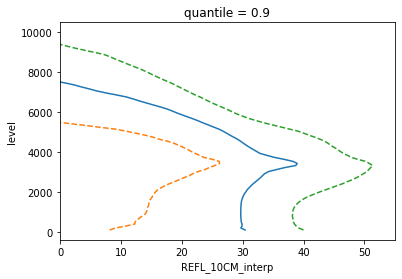

In [60]:
temp=wrf.getvar(wrflist, "REFL_10CM", timeidx=9)
hgts=wrf.getvar(wrflist, "z", timeidx=9)
temp=wrf.interplevel(temp,hgts,np.linspace(0,10000,100))
temp=temp.where(temp.max("level")>30,np.nan)
temp.quantile(.50,dim=("south_north","west_east")).plot(y="level")
temp.quantile(.10,dim=("south_north","west_east")).plot(y="level",ls="--")
temp.quantile(.90,dim=("south_north","west_east")).plot(y="level",ls="--")
plt.xlim([0,55])